In [1]:
"""
@author: albertigno

"""

from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print ('Running on: {}'.format(device))

dataset = 'nmnist'
ds_method = dataset
dataset_path = r'./../../datasets'
thresh = 0.3

if dataset == 'shd':
    batch_size = 256 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    train_path = dataset_path+'/shd_digits/shd_train.h5'
    test_path = dataset_path+'/shd_digits/shd_test.h5'
elif dataset == 'nmnist':
    batch_size = 200 
    learning_rate = 1e-4
    time_window = 25     
    train_path = dataset_path+'/nmnist/nmnist_train.mat'
    test_path = dataset_path+'/nmnist/nmnist_test.mat'   

Running on: cuda:0


In [2]:
# load datasets
print("loading test set...")
test_dataset = DatasetLoader(test_path, ds_method, time_window, 'cpu')
print("loading training set...")
train_dataset = DatasetLoader(train_path, ds_method, time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 10000
torch.Size([10000, 25, 2312]) torch.Size([10000, 10])
loading training set...
num sample: 60000
torch.Size([60000, 25, 2312]) torch.Size([60000, 10])
loading data with pytorch


In [17]:
%matplotlib notebook
from snn_models import *
%load_ext autoreload
%autoreload 1
%aimport snn_models

num_hidden = 1024
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn = RSNN('nmnist', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=0.0, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN(
  (fc_ih): Linear(in_features=2312, out_features=1024, bias=False)
  (fc_hh): Linear(in_features=1024, out_features=1024, bias=False)
  (fc_ho): Linear(in_features=1024, out_features=10, bias=False)
)

In [18]:
# training configuration
num_epochs = 10
modelname = '{}_rnn_{}_wta.t7'.format(dataset, snn.num_hidden)
num_samples = train_dataset.images.size()[0]

# super pythonic way to extract the parameters that will have 'normal' learning rate
base_params = [getattr(snn,name.split('.')[0]).weight for name, _ in snn.state_dict().items() if name[0]=='f']

# setting different learning rate for tau_m, if neeeded
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0},
        {'params': snn.tau_m_o, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

nmnist_rnn_1024_wta.t7


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

n_conn = 32

# call small world topology
watts_strogatz = nx.watts_strogatz_graph(num_hidden,n_conn,0)
mask = torch.tensor(nx.to_numpy_matrix(watts_strogatz), dtype=torch.float32, device=snn.device)

In [20]:
zero_mask = torch.zeros((num_hidden,num_hidden), device=snn.device)
inh_strength = 0.1
wta_mask = -inh_strength*torch.ones((num_hidden,num_hidden), device=snn.device) + inh_strength*torch.eye(num_hidden, device=snn.device)
wta_mask2 = -inh_strength*(1-mask) + inh_strength*torch.eye(num_hidden, device=snn.device)
wta_mask3 = 0.01*(mask) + 0.01*torch.eye(num_hidden, device=snn.device)
#snn.mask_weights(snn.fc_hh, wta_mask, override = True, trainable=False )
snn.mask_weights(snn.fc_hh, wta_mask3, override = True, trainable=False)

<IPython.core.display.Javascript object>


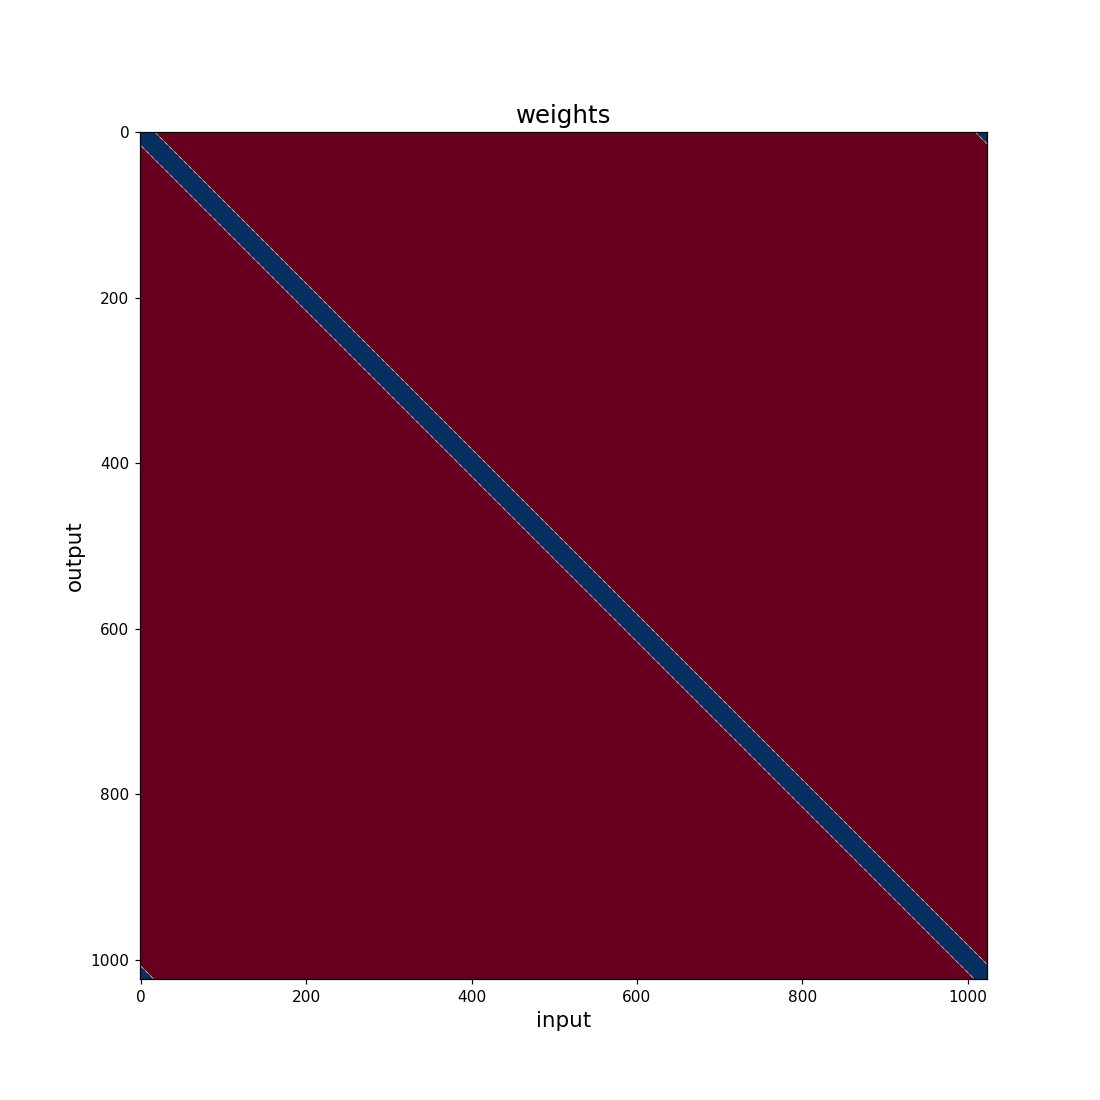

In [21]:
q = snn.plot_weights('hh', 'matrix')

In [22]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples)
    t = time.time() - start_time
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    # taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch+1) % 5 ==0:
        snn.test(test_loader, criterion=nn.MSELoss())
        snn.save_model(modelname)   
                
with open('training_log', 'a') as logs:
    logs.write("\nFinished training {} epochs for {}, batch_size {}, time_per_epoch {} s".format(num_epochs, modelname, batch_size, t))       

Epoch [1/10]
Step [100/300], Loss: 5.76153
Step [200/300], Loss: 3.58658
Step [300/300], Loss: 3.06155
Time elasped: 13.572329044342041
Epoch [2/10]
Step [100/300], Loss: 2.67760
Step [200/300], Loss: 2.34738
Step [300/300], Loss: 2.11563
Time elasped: 13.637943506240845
Epoch [3/10]
Step [100/300], Loss: 1.89561
Step [200/300], Loss: 1.76240
Step [300/300], Loss: 1.62501
Time elasped: 13.563924074172974
Epoch [4/10]
Step [100/300], Loss: 1.49639
Step [200/300], Loss: 1.43919
Step [300/300], Loss: 1.37445
Time elasped: 13.764003038406372
Epoch [5/10]
Step [100/300], Loss: 1.27671
Step [200/300], Loss: 1.22449
Step [300/300], Loss: 1.16915
Time elasped: 14.656001329421997
avg spk_count per neuron for all 25 timesteps 5.618977069854736
Test Accuracy of the model on the test samples: 96.310
Epoch [6/10]
Step [100/300], Loss: 1.10642
Step [200/300], Loss: 1.07363
Step [300/300], Loss: 1.03517
Time elasped: 14.611003398895264
Epoch [7/10]
Step [100/300], Loss: 0.97249
Step [200/300], Loss: 

In [9]:
#snn.save_to_numpy(modelname.split('.')[0])

<IPython.core.display.Javascript object>


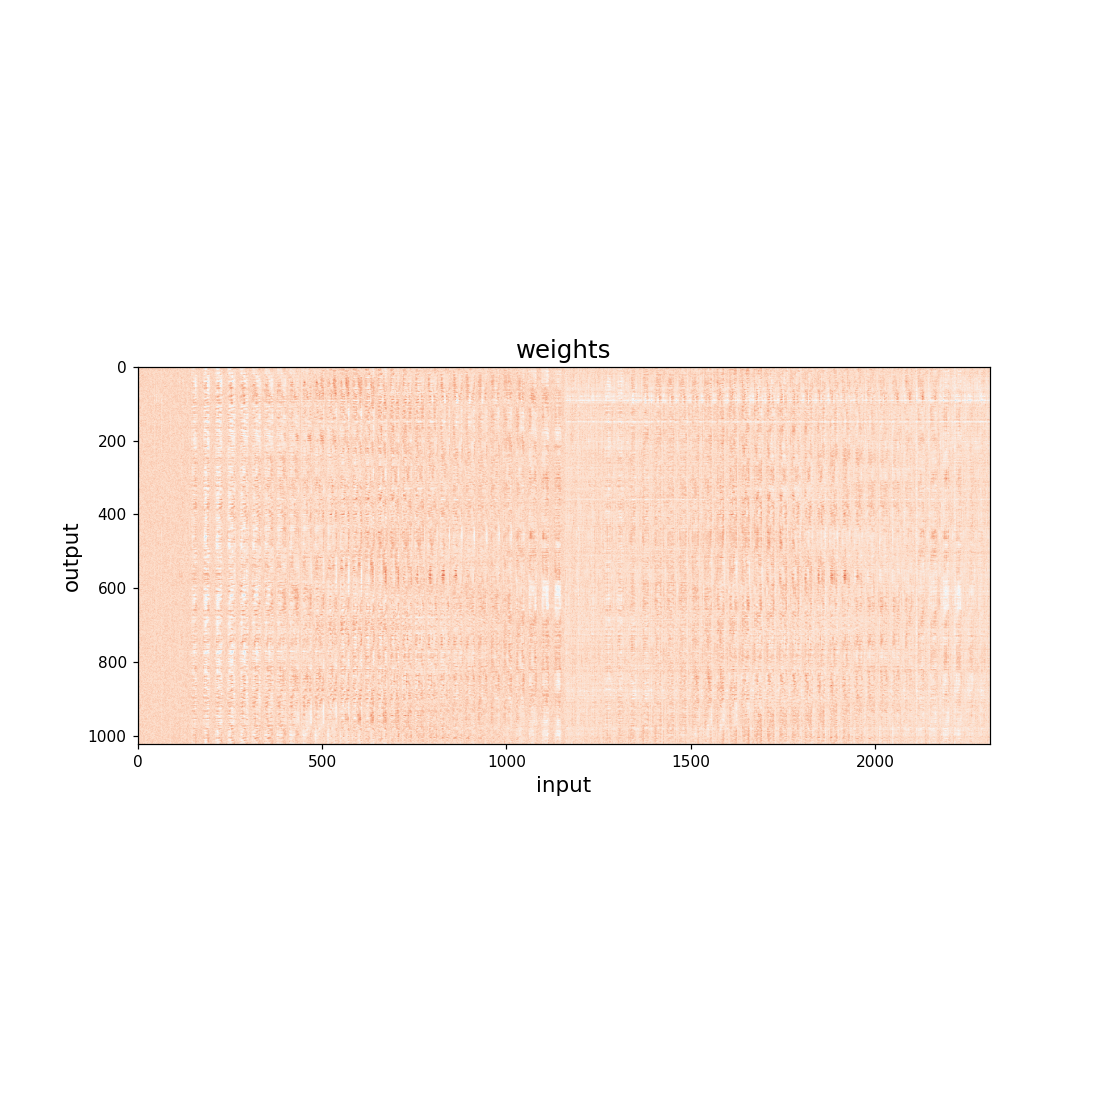

In [11]:
w = snn.plot_weights('ih', 'matrix')

<IPython.core.display.Javascript object>


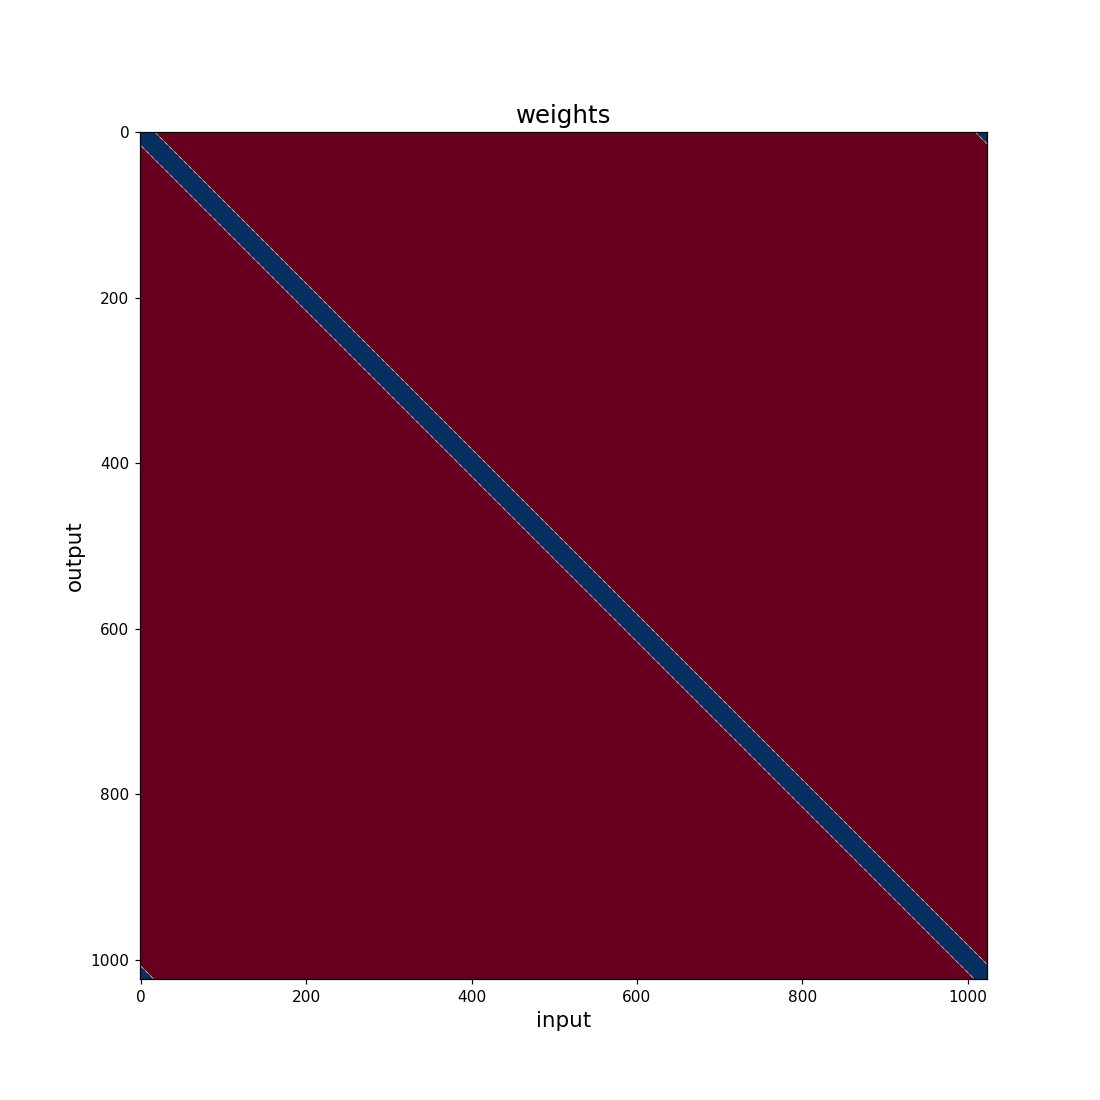

In [12]:
w = snn.plot_weights('hh', 'matrix')

In [13]:
from snn_models_monitor import *
snn2 = RSNN_monitor()

In [14]:
snn2.load_model(modelname, batch_size=200)

In [15]:
snn2.test_gpu(test_loader, criterion=nn.MSELoss())

avg spk_count per neuron for all 25 timesteps 6.221457481384277
Test Accuracy of the model on the test samples: 97.330


<IPython.core.display.Javascript object>


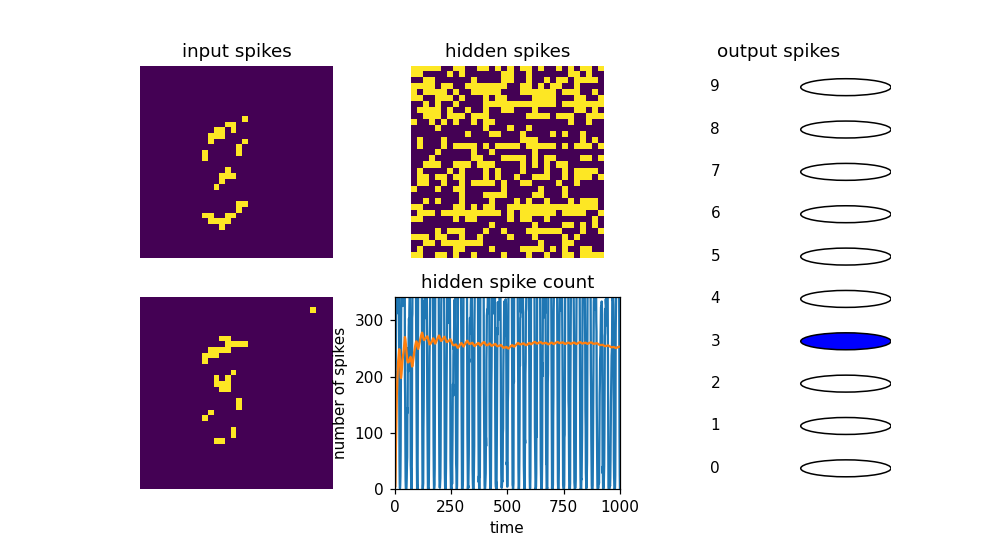

In [16]:
from matplotlib.animation import FuncAnimation
#class_names = ['em_stp', 'mv_ahd', 'mv_bk1', 'mv_bk2', 'sl_dwn', 'sa_eng', 'so_eng', 'st_ahd', 'tn_lft', 'tn_rht']
anim = snn2.animation(anim_frames = 1000)
plt.show()